## ANLY580 Project 2
## Home Depot Product Search Relevance
### 400 Bad Request -- Zhengqian Xu, Hongyang Zheng, Heng Zhou

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import nltk
import requests
import ast
import time
import lxml
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from IPython.core.interactiveshell import InteractiveShell
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV,RidgeCV
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#InteractiveShell.ast_node_interactivity = "all"
stemmer = SnowballStemmer('english')

D:\Program Files\anaconda\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
D:\Program Files\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data Loading

We load the three datasets and then join descriptions on both training and test dataset using `product_uid` as the common key.

In [2]:
# Load the data
train = pd.read_csv("data/train.csv", encoding="ISO-8859-1")
descriptions = pd.read_csv('data/product_descriptions.csv')

In [3]:
# Take a look
train.head()
len(train.product_uid.unique())

54667

In [4]:
descriptions.head()
len(descriptions.product_uid.unique())

124428

In [5]:
# Merge data on training data
train1=pd.merge(train, descriptions, how='left', on='product_uid')
train1.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


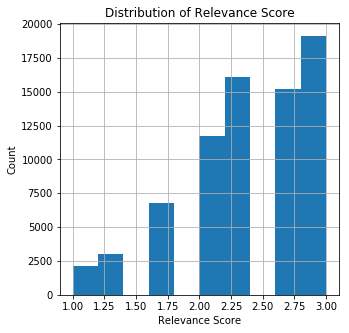

In [6]:
# Plot a histogram of relevance score
train1.relevance.hist(figsize=(5,5))
plt.title('Distribution of Relevance Score')
plt.xlabel('Relevance Score')
plt.ylabel('Count')
plt.show()

### Data Cleaning

We clean the columns `product_title`, `search term`, and `product_description`.

In [11]:
# Remove html tag for description
def remove_html(df):
    # Find html rows
    index = df.product_description.str.contains('<br')
    df.loc[index, 'product_description'] = df.loc[index, 'product_description'].apply(lambda x:remove_html_tag(x))
    return df 

def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

In [7]:
# Remove punctuation and stop words for description
def cleanword(text):

    tokens = nltk.casual_tokenize(text.lower())
    
    # Stemmer for each token
    tokens = [stemmer.stem(term) for term in tokens]
    
    # Remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [term.translate(table) for term in tokens]
    
    # Remove tokens that are not alphabetic
    tokens = [term for term in tokens if term.isalpha()]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [term for term in tokens if not term in stop_words]
    
    # Remove tokens with length that is less than 2
    tokens = [term for term in tokens if len(term) > 1]
    
    return ' '.join(tokens)

# Stemmer for all text variables
def str_stemmer(text):
    tokens = nltk.casual_tokenize(text.lower())
    tokens = [stemmer.stem(term) for term in tokens]
    # Remove tokens with length that is less than 2
    tokens = [term for term in tokens if len(term) > 1]
    
    return ' '.join(tokens)

In [8]:
# Read a file that contains the typo for search term
# The file is adapted from https://www.kaggle.com/steubk/fixing-typos which uses google API
# Replace typo with correct spelling
def spell_correct(text):
    with open("data/Spelling.txt") as f:
        error = ast.literal_eval(f.read())
    for key, value in error.items():
        if text in key:
            text = text.replace(key, value)    
    return text

In [9]:
# Select a subset of 30,000 rows from orginal data
trainsub=train1.sample(n = 30000, replace = False)

#### For Product Description

In [12]:
# Remove html tags
train2 = remove_html(trainsub)

# Remove punctuation, stop words and stemmer
train2['product_description'] = train2['product_description'].apply(lambda x: cleanword(x))

In [13]:
# New column to store the tokens
train2['description_token'] = train2['product_description'].apply(lambda x: nltk.casual_tokenize(x))

#### For Search Term

In [14]:
# Stemmer
train2['search_term'] = train2['search_term'].apply(lambda x: str_stemmer(x))

# Correct typo
train2['search_term'] = train2['search_term'].apply(lambda x: spell_correct(x))

In [15]:
# New column to store the tokens
train2['search_token'] = train2['search_term'].apply(lambda x: nltk.casual_tokenize(x))

#### For Product Title

In [16]:
# Stemmer
train2['product_title'] = train2['product_title'].apply(lambda x: str_stemmer(x))

In [17]:
# New column to store the tokens
train2['title_token'] = train2['product_title'].apply(lambda x: nltk.casual_tokenize(x))

### Feature Engineering

In [18]:
train3=train2.copy()

We generate some new features based on the text variables, for example:
* length for search term, product title, product description
* the number of common words between search term and product title, search term and product description
* the number of shared words between search term, product title and product description
* fuzzywuzzy similarity between search term and product title, search term and product description
* cosine similarity between search term and product title, search term and product description
* jaccard similarity between search term and product title

In [19]:
# Find common words
def str_common_word(str1, str2):
    whole_set = set(str1.split())
    return sum(int(str2.find(word)>=0) for word in whole_set)

def get_shared_words(row_data):
    return np.sum([str_common_word(*row_data[:-1]), str_common_word(*row_data[1:])])

In [20]:
# Cosine similarity
def cosine_sim(sent1,sent2,stopwords=None):
    if stopwords is None:
        stopwords = []
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # Build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # Build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1-cosine_distance(vector1, vector2)


In [21]:
# Jaccard similarity
def jaccard_sim(listA,listB): 
    inter = set([i for i in listA if i in listB])
    union = set(listA+listB)
    return len(inter)/len(union)

In [22]:
def feature(train3):
    # Length of tokens
    train3['length_search']=train3['search_token'].map(lambda x: len(x))
    train3['length_title']=train3['title_token'].map(lambda x: len(x))
    train3['length_description']=train3['description_token'].map(lambda x: len(x))
    # The number of common words
    train3['number_of_common_1'] = [str_common_word(word1, word2) for word1, word2 in train3[['search_term','product_title']].values.tolist()]
    train3['number_of_common_2'] = [str_common_word(word1, word2) for word1, word2 in train3[['search_term','product_description']].values.tolist()]
    # The number of shared words
    train3['number_of_shared_words'] = list(map(get_shared_words, train3[['search_term','product_description', 'product_title']].values))
    # The ratio of common words
    train3['ratio_1'] = train3['number_of_common_1']/train3['length_search']
    train3['ratio_2'] = train3['number_of_common_2']/train3['length_search']
    # Fuzzywuzzy similarity
    train3['simple_ratio']=[fuzz.ratio(word1, word2) for word1, word2 in train3[['search_term','product_title']].values.tolist()]
    train3['sort_ratio']=[fuzz.token_sort_ratio(word1, word2) for word1, word2 in train3[['search_term','product_title']].values.tolist()]
    # Cosine similarity
    train3['cosine_score'] = [cosine_sim(word1, word2) for word1, word2 in train3[['search_token','title_token']].values.tolist()]
    # Jaccard similarity
    train3['jaccard_score'] = [jaccard_sim(word1, word2) for word1, word2 in train3[['search_token','title_token']].values.tolist()]
    
    return train3

In [23]:
train3 = feature(train3)

In [24]:
train3.head()

,id,product_uid,product_title,search_term,relevance,product_description,description_token,search_token,title_token,length_search,...,length_description,number_of_common_1,number_of_common_2,number_of_shared_words,ratio_1,ratio_2,simple_ratio,sort_ratio,cosine_score,jaccard_score
1176,3669,100640,frigidair 27.19 cu ft french door refriger in ...,custom order french door,2.33,frigidair cu ft stainless steel french door re...,"[frigidair, cu, ft, stainless, steel, french, ...","[custom, order, french, door]","[frigidair, 27.19, cu, ft, french, door, refri...",4,...,249,2,2,10,0.5,0.500000,35,45,0.316228,0.166667
53066,161075,162458,eureka 6.5 amp dual motor commerci vacuum,eureka,1.67,motor upright vacuum power clean surfac dust d...,"[motor, upright, vacuum, power, clean, surfac,...",[eureka],"[eureka, 6.5, amp, dual, motor, commerci, vacuum]",1,...,64,1,0,4,1.0,0.000000,26,26,0.377964,0.142857
59370,179376,174101,1/2 in cpvc spigot slip bush,cpvc 3/4 hose spigot,2.33,connect pipe pvc cpvc spigot slip bush cpvc bu...,"[connect, pipe, pvc, cpvc, spigot, slip, bush,...","[cpvc, 3/4, hose, spigot]","[1/2, in, cpvc, spigot, slip, bush]",4,...,27,2,2,7,0.5,0.500000,46,62,0.408248,0.250000
36665,112098,136813,power care 1/4 in npt-f 3/8 in npt-m and 1/4 i...,3/8 npt 1/8 npt brass bush,2.33,power care nptf nptm set reduc bush featur dur...,"[power, care, nptf, nptm, set, reduc, bush, fe...","[3/8, npt, 1/8, npt, brass, bush]","[power, care, 1/4, in, npt-f, 3/8, in, npt-m, ...",6,...,45,3,2,8,0.5,0.333333,36,48,0.150756,0.142857
27095,83137,124542,gardner bender wiregard #18 #10 awg mmå high p...,thermoplast,2.67,wiregard twiston wire connector design general...,"[wiregard, twiston, wire, connector, design, g...",[thermoplast],"[gardner, bender, wiregard, #18, #10, awg, mmå...",1,...,151,0,1,5,0.0,1.000000,12,14,0.000000,0.000000


### Exploratory Data Analysis

In [25]:
# Drop NA value
train3 = train3.dropna()

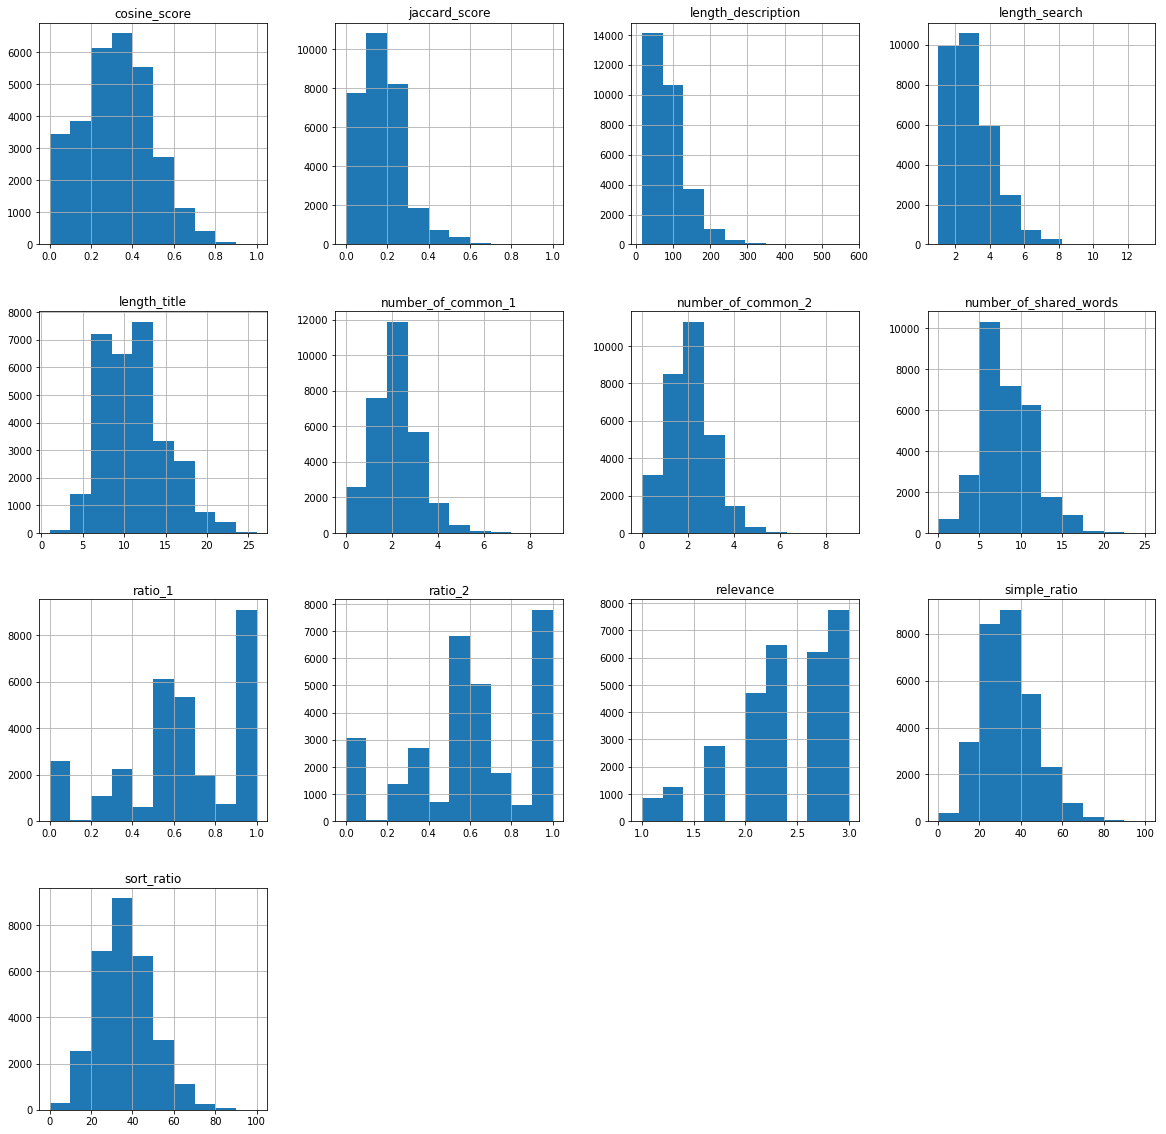

In [26]:
# Plot histogram for useful columns
train4 = train3.drop(['id','product_uid'],axis=1)
train4.hist(figsize=(20,20))
plt.show()

* Some columns have similar distribution, such as `cosine_score`, `jaccard_score`,`length_description`.
* Some columns have similar normal distribution, such as `number_of_shared_words`, `simple_ratio`, `sort_ratio`.

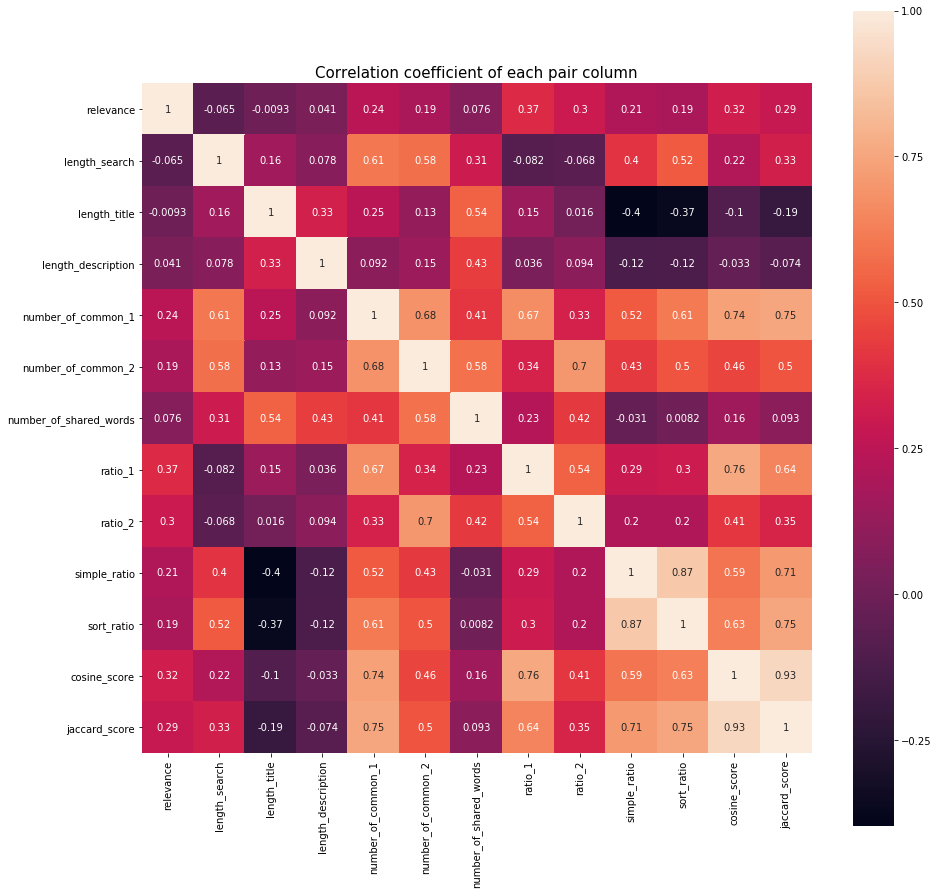

In [27]:
# Make a correlation heatmap of data
graph = train4.corr()
plt.subplots(figsize=(15, 15)) 
sns.heatmap(graph, annot=True, vmax=1, square=True)
plt.title('Correlation coefficient of each pair column',fontsize=15)
plt.show()

* Some features are highly correlated such as `cosine_score` and `jaccard_score` , so we need to be careful if build linear models.

* ratio_1 has the strongest relationship with relevance.

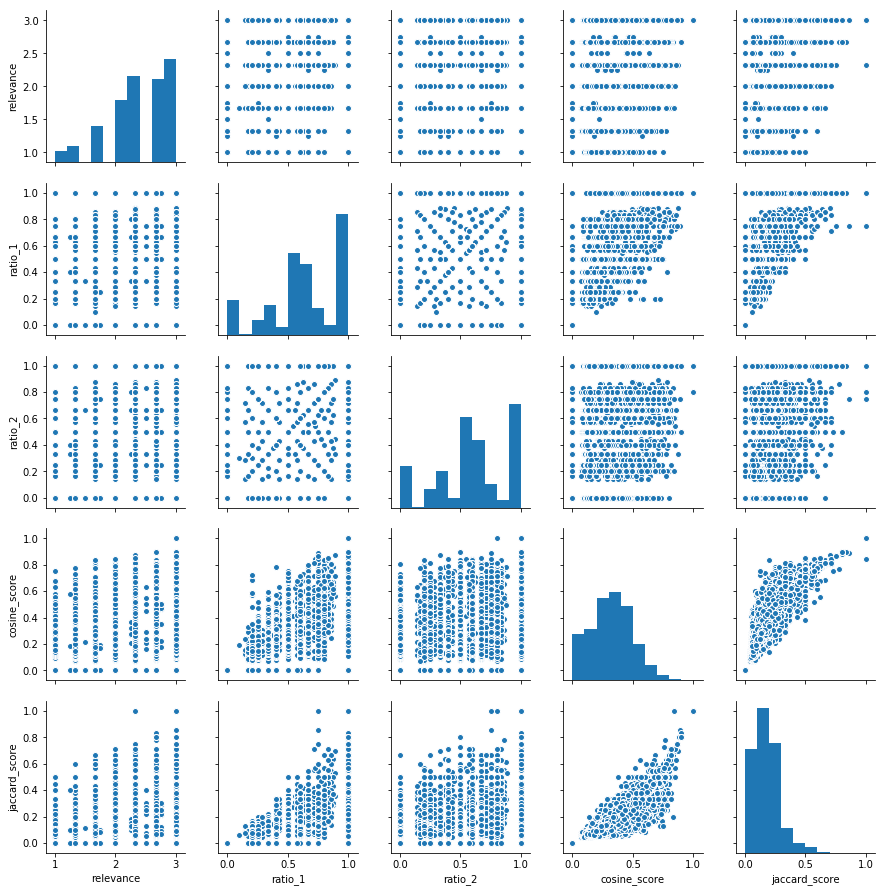

In [28]:
# Make a pairplot for columns whose correlation with relevance is greater than 0.3.
sns.pairplot(train3.drop(['id','product_uid','length_search','length_title','length_description','number_of_shared_words','sort_ratio','number_of_common_1','number_of_common_2','simple_ratio'],axis=1))
plt.show()

### Model Building

In [29]:
# Check null value
print("Has blank/empty values? ",train3.isnull().values.any())

Has blank/empty values?  False


In [30]:
# Split data into training and test data
y = train4['relevance'].values
x = train4.drop(['product_title', 'search_term', 'relevance','product_description', 'description_token', 'search_token','title_token'],axis=1)

X_train, X_test , y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

#### 1. Lasso

##### First we build a linear model as a benchmark. Here we choose to use lasso model since it can do a automatic feature selection. 

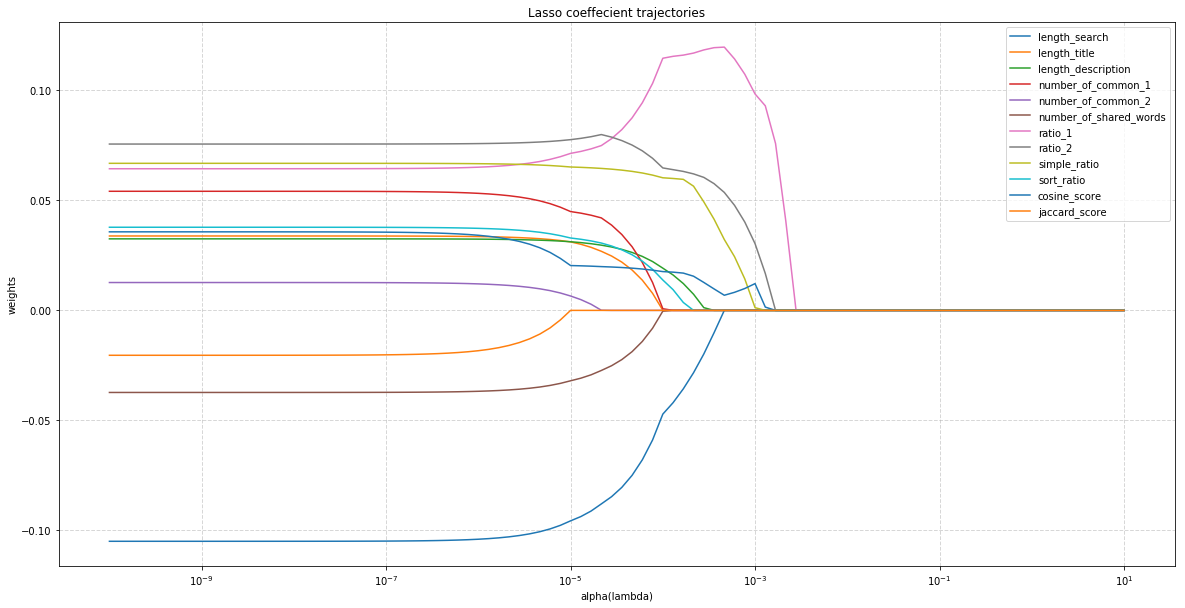

In [31]:
# Fit to lasso
lasso = Lasso(max_iter=10000, normalize=True)
lasso_coefs = []
alphas = 10**np.linspace(1, -10, 100)*0.5

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(scale(X_train), y_train)
    lasso_coefs.append(lasso.coef_)
    
# Visualize the coefficients
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.gca()

ax.plot(alphas*2, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha(lambda)')
plt.ylabel('weights')
plt.title('Lasso coeffecient trajectories')
plt.grid(which='major', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(X_train.columns, loc=1)
plt.show()

In [32]:
# The last columns in the model
names = X_train.columns
coef = Lasso(alpha = 0.001, max_iter=10000, normalize=True).fit(X_train, y_train).coef_
names[abs(coef)!=0]
print('The most important variable is: ratio_1')

The most important variable is: ratio_1


In [33]:
# Build Lasso with cross validation
lassocv = LassoCV(cv=5, max_iter=1000, normalize=True)
lassocv.fit(X_train,y_train)

# Optimal value of penalty 
print(lassocv.alpha_)

1.3580129280171343e-06


In [34]:
# Use optimal alpha to fit
lasso2 = Lasso(max_iter=10000, normalize=True)
lasso2.set_params(alpha = lassocv.alpha_)
lasso2.fit(X_train, y_train)
y_pred1 = lasso2.predict(X_test)

# Print out the error
error1 = (mean_squared_error(y_test, y_pred1))**0.5
print('RMSE of lasso:',error1)

RMSE of lasso: 0.4843725432805108


#### 2. Random Forest

In [35]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6,7],
    'n_estimators': [200,400,600]
}

# Use random forest model
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)

In [36]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [5, 6, 7], 'n_estimators': [200, 400, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
# Find the best parameter
grid_search.best_params_

# Use random forest model
rf_best = RandomForestRegressor(**grid_search.best_params_)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
# Make prediction
y_pred2 = rf_best.predict(X_test)
error2=(mean_squared_error(y_test, y_pred2))**0.5
print('RMSE of rf:',error2)

RMSE of rf: 0.47716913763909097


#### 3. Xgboost

In [39]:
# Use xgboost model
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6,8],
                    'n_estimators': [20,50,100,200]}, verbose=1)

clf.fit(X_train , y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[22:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is 

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.1min finished


[22:03:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.19688593968082146
{'max_depth': 4, 'n_estimators': 100}


In [40]:
xgb_best = xgb.XGBRegressor(**clf.best_params_)
xgb_best.fit(X_train,y_train)

# Make prediction
y_pred3 = xgb_best.predict(X_test)
error3=(mean_squared_error(y_test, y_pred3))**0.5
print('RMSE of rf:',error3)

[22:03:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE of rf: 0.47671738142138403


#### 4. Chain model withing pipeline

In [41]:
# Define standard scaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)
scaled_train_data = scaler.transform(X_train)
scaled_test_data = scaler.transform(X_test)

# Choose the best two models
rf1 = RandomForestRegressor(**grid_search.best_params_)
clf1 = BaggingRegressor(rf1, n_estimators=4, max_samples=0.1, random_state=25)

# Build pipeline
pipeline = Pipeline(steps = [('scaling', scaler), ('baggingregressor', clf1)])
pipeline.fit(X_train, y_train)
y_pred4 = pipeline.predict(X_test)

In [42]:
# Make prediction
error4=(mean_squared_error(y_test, y_pred4))**0.5
print('RMSE of rf:',error4)

RMSE of rf: 0.4799731842610267


### Results

Let's compare the performance from above models

In [43]:
Score_list = [['Lasso', error1], 
           ['Random Forest', error2], 
           ['Xgboost', error3],
             ['Chain model withing pipeline', error4]] 
    
Score_df = pd.DataFrame(Score_list, columns =['Model Name','RMSE'], dtype = float) 
Score_df

,Model Name,RMSE
0,Lasso,0.484373
1,Random Forest,0.477169
2,Xgboost,0.476717
3,Chain model withing pipeline,0.479973


From above we can see that the Xgboost model has the best performance, with RMSE about 0.48

### Application

Given a search term, return top 10 relevant product based on our best model: xgboost.

In [53]:
# Create a dataframe to store new information from the user
df2 = pd.DataFrame(columns=['length_search', 'length_title', 'length_description',
       'number_of_common_1', 'number_of_common_2', 'number_of_shared_words','ratio_1', 'ratio_2',
        'simple_ratio', 'sort_ratio', 'cosine_score','jaccard_score'])
df2['title_token']=train3['title_token']
df2['description_token']=train3['description_token']
df2['product_title']=train3['product_title']
df2['product_description']=train3['product_description']

In [54]:
# Function for compute similarities
def find_relevance(df2,input_search):
    df2['search_term']=input_search
    df2['search_token'] = [str_stemmer(input_search).split(' ')]*len(df2)
    df2 = feature(df2)

    return df2

In [55]:
# Input a key word
input_search = input('Please input your key word:')
df2 = find_relevance(df2,input_search)

Please input your key word:battery


In [56]:
# Reindex our dataframe
df2=df2.reset_index(drop=True)
df2.head()

,length_search,length_title,length_description,number_of_common_1,number_of_common_2,number_of_shared_words,ratio_1,ratio_2,simple_ratio,sort_ratio,cosine_score,jaccard_score,title_token,description_token,product_title,product_description,search_term,search_token
0,1,10,249,0,0,8,0.0,0.0,12,12,0.0,0.0,"[frigidair, 27.19, cu, ft, french, door, refri...","[frigidair, cu, ft, stainless, steel, french, ...",frigidair 27.19 cu ft french door refriger in ...,frigidair cu ft stainless steel french door re...,battery,[batteri]
1,1,7,64,0,0,4,0.0,0.0,17,12,0.0,0.0,"[eureka, 6.5, amp, dual, motor, commerci, vacuum]","[motor, upright, vacuum, power, clean, surfac,...",eureka 6.5 amp dual motor commerci vacuum,motor upright vacuum power clean surfac dust d...,battery,[batteri]
2,1,6,27,0,0,5,0.0,0.0,6,11,0.0,0.0,"[1/2, in, cpvc, spigot, slip, bush]","[connect, pipe, pvc, cpvc, spigot, slip, bush,...",1/2 in cpvc spigot slip bush,connect pipe pvc cpvc spigot slip bush cpvc bu...,battery,[batteri]
3,1,14,45,0,0,6,0.0,0.0,6,17,0.0,0.0,"[power, care, 1/4, in, npt-f, 3/8, in, npt-m, ...","[power, care, nptf, nptm, set, reduc, bush, fe...",power care 1/4 in npt-f 3/8 in npt-m and 1/4 i...,power care nptf nptm set reduc bush featur dur...,battery,[batteri]
4,1,15,151,0,0,4,0.0,0.0,4,11,0.0,0.0,"[gardner, bender, wiregard, #18, #10, awg, mmå...","[wiregard, twiston, wire, connector, design, g...",gardner bender wiregard #18 #10 awg mmå high p...,wiregard twiston wire connector design general...,battery,[batteri]


In [57]:
# Use the same variables to fit 
df_train=df2.iloc[:,:12]

In [58]:
# Fit to xgboost
df2['relevance']= xgb_best.predict(df_train)

In [60]:
# Create a result dataframe to return top 10 related products
result = pd.DataFrame(columns=['relevance_score','product_title','product_description'])
result['relevance_score'] = list(df2.sort_values(by='relevance',ascending=False)[['relevance']][:10].values[:,0])
result['product_title'] = list(df2.sort_values(by='relevance',ascending=False)[['product_title']][:10].values[:,0])
result['product_description'] = list(df2.sort_values(by='relevance',ascending=False)[['product_description']][:10].values[:,0])

In [61]:
result

,relevance_score,product_title,product_description
0,2.503572,exid xtra batteri,ordinari golf cart electr vehicl requir extrao...
1,2.428497,univers secur instrument smoke sens battery-op...,univers secur instrument mds univers smoke sen...
2,2.404011,bathroom,latest idea design materi along essenti remode...
3,2.391639,zareba garden protector battery-pow electr fen...,conveni batteri power use remot area zareba el...
4,2.359105,home accent holiday 12 ft batteri oper frost m...,spruce home holiday classic decor christma gar...
5,2.359105,home accent holiday ft batteri oper plaza pot ...,decor home entryway christma ft cordless led p...
6,2.356830,nation tree compani ft poinsettia garland with...,decor ft batteryoper prelit poinsettia garland...
7,2.354548,connecticut electr 20 amp mini-break,minibreak edison base resett circuit protector...
8,2.347199,tripp lite 750va 450 watt up desktop batteri b...,offer standbi protect pcs peripher prevent dat...
9,2.345447,home accent holiday 12 ft battery-oper meadow ...,hang readytous garland entryway fireplac anywh...


This is a demo to display the application. We can see that when we input `battery`, the result returns top 10 relevant products under xgboosting model. Most of them are related to `battery`, but still has some unrelated products.

Given a search term, return top 10 relevant product based on different similarity score.

In [66]:
result = pd.DataFrame(columns=['jaccard_list','cosine_list','fuzzy_list'])
result['jaccard_list'] = list(df2.sort_values(by='jaccard_score',ascending=False)[['product_title']][:10].values[:,0])
result['cosine_list'] = list(df2.sort_values(by='cosine_score',ascending=False)[['product_title']][:10].values[:,0])
result['fuzzy_list'] = list(df2.sort_values(by='simple_ratio',ascending=False)[['product_title']][:10].values[:,0])

In [67]:
result

,jaccard_list,cosine_list,fuzzy_list
0,exid titan titan batteri,batteri tender 12 volt car-to-car batteri char...,bathroom
1,exid xtra batteri,batteri tender 12 volt 1.25- amp batteri charger,exid xtra batteri
2,energ alkalin batteri pack,batteri doctor wall mount ii 12 volt amp batte...,104 tube cutter
3,makita 12 volt ni-mh batteri,exid xtra batteri,ft steel curb key
4,ryobi 40 volt lithium-ion batteri,batteri doctor 12 volt 1.25- amp automot sport...,water cannon
5,ridgid 12 volt batteri charger,energ alkalin batteri pack,no 15 tube cutter
6,worx 40 volt lithium-ion batteri,kidd ac plug-in carbon monoxid detector digit ...,magnet vent cover
7,energ volt advanc lithium batteri,first alert batteri power combin pack smoke an...,magnet vent cover
8,rayovac alkalin batteri 12 pack,barska cr123a volt batteri piec,edg 65 auto agm batteri
9,rayovac alkalin batteri 12 pack,ridgid 12 volt batteri charger,magnet tool holder


Jaccard and cosine similarity seem better than fuzzy for the result.